# Lie Factor Quantification

Teng-Jui Lin

- Created: 2023-05-28
- Edited: 2024-05-28

In [1]:
from bar_constants import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Control Experiment Bar Graphs

### Control 1

(0.0, 60.0)

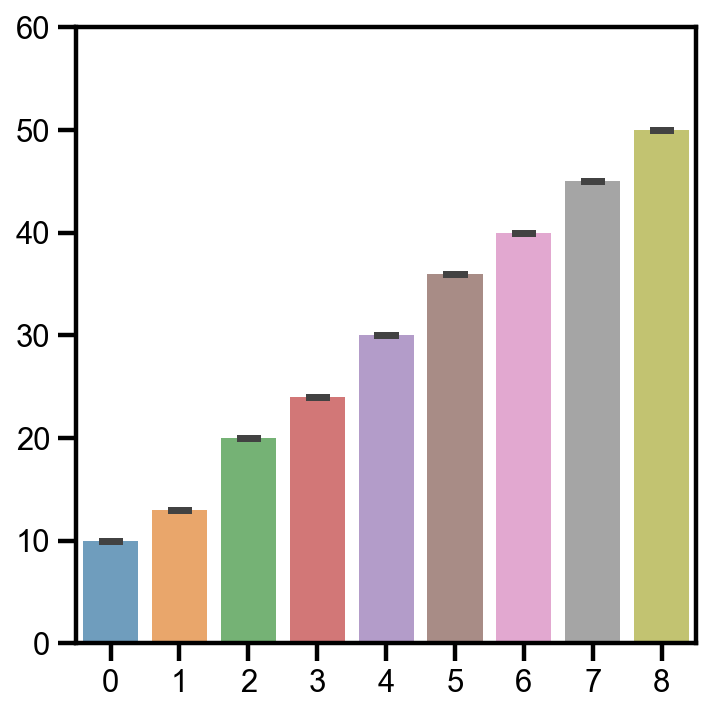

In [2]:
bar_df = pd.DataFrame(np.hstack([
    10 + np.zeros([SAMPLE_SIZE, 1]), 
    13 + np.zeros([SAMPLE_SIZE, 1]), 
    20 + np.zeros([SAMPLE_SIZE, 1]), 
    24 + np.zeros([SAMPLE_SIZE, 1]), 
    30 + np.zeros([SAMPLE_SIZE, 1]), 
    36 + np.zeros([SAMPLE_SIZE, 1]), 
    40 + np.zeros([SAMPLE_SIZE, 1]), 
    45 + np.zeros([SAMPLE_SIZE, 1]), 
    50 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 60)

In [3]:
def get_size_of_effect(series):
    # get permutations of all items as 2d array
    comb_arr = itertools.permutations(series, 2)
    comb_arr = np.array(list(comb_arr))
    # calculate size of effect for each permutation as series
    effect = np.diff(comb_arr).reshape(-1) / comb_arr[:, 0]
    effect = pd.Series(effect)
    return effect


def _get_lie_factor(viz_series, val_series):
    return get_size_of_effect(viz_series) / get_size_of_effect(val_series)


def get_lie_factor(viz_series, val_series):
    return viz_series / val_series

In [4]:
control1_val_series = pd.Series(np.array([10, 13, 20, 24, 30, 36, 40, 45, 50]))
control1_val_series.name = 'Data Value'
control1_val_series

0    10
1    13
2    20
3    24
4    30
5    36
6    40
7    45
8    50
Name: Data Value, dtype: int64

In [5]:
control1_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig1.csv'), header=None, index_col=0)
control1_viz_df = control1_viz_df.reset_index(drop=True)
control1_viz_series = control1_viz_df.iloc[:, 0]
control1_viz_series.name = 'Visual Value'
control1_viz_series

0     9.868491
1    12.887194
2    19.898377
3    23.890856
4    29.928263
5    35.868292
6    39.860771
7    44.924403
8    49.890657
Name: Visual Value, dtype: float64

In [6]:
lie_factor_df = _get_lie_factor(control1_viz_series, control1_val_series)

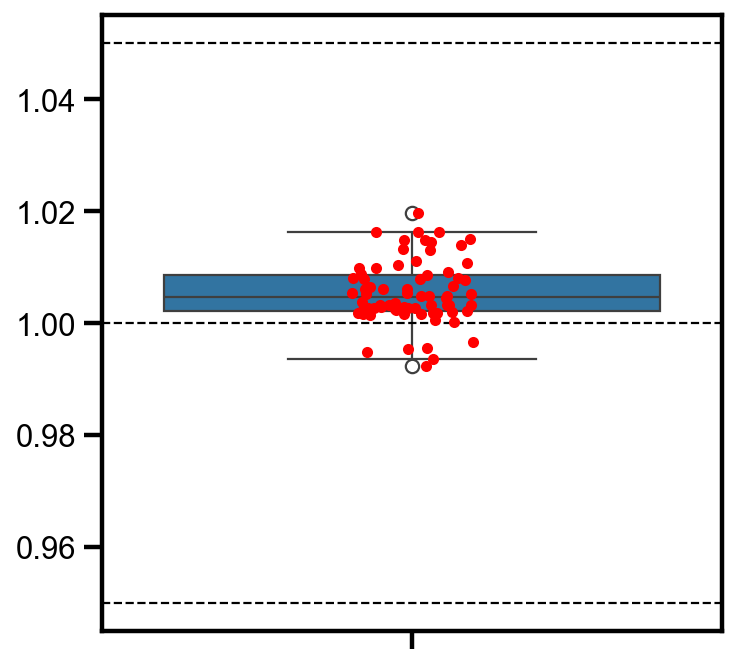

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

### Control 2

(0.0, 140.0)

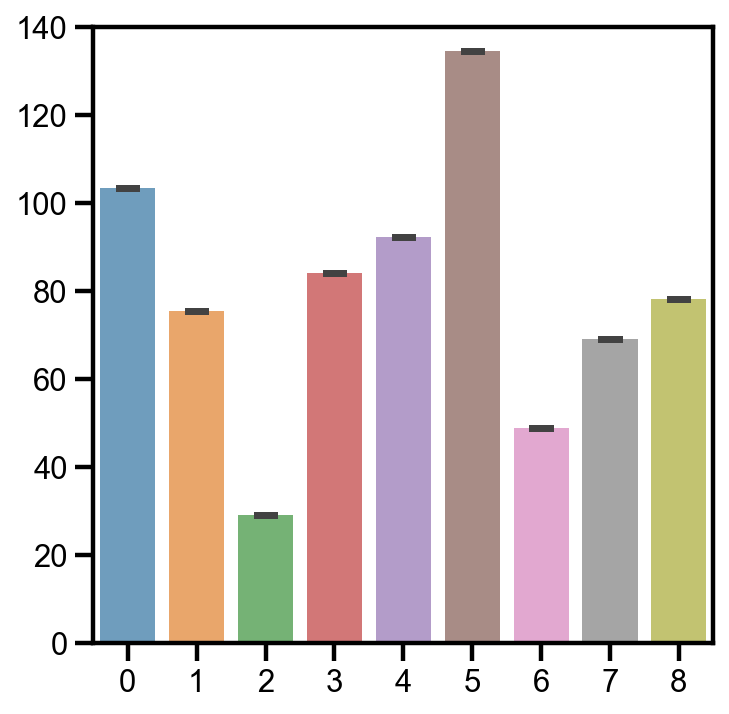

In [38]:
bar_df = pd.DataFrame(np.hstack([
    103.4 + np.zeros([SAMPLE_SIZE, 1]), 
    75.6 + np.zeros([SAMPLE_SIZE, 1]), 
    29.2 + np.zeros([SAMPLE_SIZE, 1]), 
    84.1 + np.zeros([SAMPLE_SIZE, 1]), 
    92.3 + np.zeros([SAMPLE_SIZE, 1]), 
    134.6 + np.zeros([SAMPLE_SIZE, 1]), 
    48.9 + np.zeros([SAMPLE_SIZE, 1]), 
    69.3 + np.zeros([SAMPLE_SIZE, 1]), 
    78.3 + np.zeros([SAMPLE_SIZE, 1]),
]))

fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(
    bar_df,
    errorbar=BAR_ERRORBAR,
    capsize=BAR_CAPSIZE,
    linewidth=BAR_LINEWIDTH,
    edgecolor=BAR_EDGECOLOR,
    alpha=BAR_ALPHA,
    width=BAR_WIDTH,
    ax=ax,
)
# ax.set_box_aspect(2)
ax.set_ylim(0, 140)

In [39]:
control2_val_series = pd.Series(np.array([103.4, 75.6, 29.2, 84.1, 92.3, 134.6, 48.9, 69.3, 78.3]))
control2_val_series.name = 'Data Value'
control2_val_series

0    103.4
1     75.6
2     29.2
3     84.1
4     92.3
5    134.6
6     48.9
7     69.3
8     78.3
Name: Data Value, dtype: float64

In [40]:
control2_viz_df = pd.read_csv(os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'control', 'control_fig2.csv'), header=None, index_col=0)
control2_viz_df = control2_viz_df.reset_index(drop=True)
control2_viz_series = control2_viz_df.iloc[:, 0]
control2_viz_series.name = 'Visual Value'
control2_viz_series

0    103.233107
1     75.285755
2     28.934049
3     83.919896
4     92.099609
5    134.361458
6     48.701688
7     68.923756
8     78.012326
Name: Visual Value, dtype: float64

In [41]:
lie_factor_df = _get_lie_factor(control2_viz_series, control2_val_series)

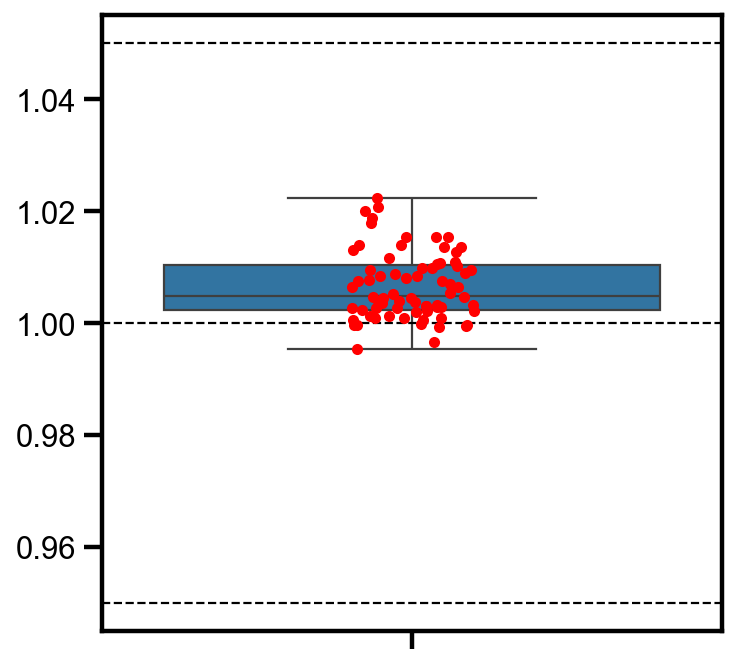

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(
    lie_factor_df,
    ax=ax,
    log_scale=False,
)
sns.stripplot(
    lie_factor_df,
    ax=ax,
    color='r',
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

<Axes: ylabel='Count'>

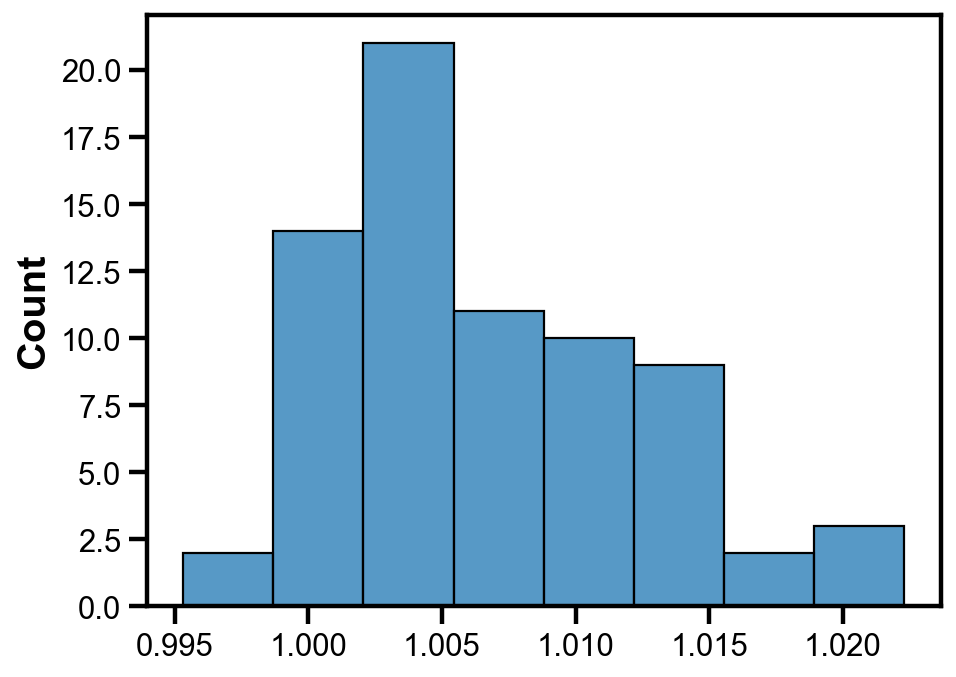

In [43]:
sns.histplot(lie_factor_df)

## Nature Biomedical Engineering

### Log

In [13]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', LOG_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VAL_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [14]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    val_df = pd.read_csv(filepath, header=None, index_col=0)
    val_df = val_df.reset_index(drop=True)
    val_series = val_df.iloc[:, 0]
    val_series.name = 'Data Value'
    val_effect_series = get_size_of_effect(val_series)
    raw_df_dict[fignames[i]] = val_effect_series

In [15]:
val_series = pd.concat(raw_df_dict)
val_series

10.1038:s41551-023-01143-w_log_fig4  0     -0.104353
                                     1      1.095885
                                     2      0.099071
                                     3     -0.197817
                                     4     -0.702488
                                              ...   
10.1038:s41551-023-01143-w_log_fig1  235   -0.959726
                                     236   -0.615162
                                     237   -0.619905
                                     238   -0.995048
                                     239    0.132035
Length: 11296, dtype: float64

In [16]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', LOG_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VIZ_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [17]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    viz_df = pd.read_csv(filepath, header=None, index_col=0)
    viz_df = viz_df.reset_index(drop=True)
    viz_series = viz_df.iloc[:, 0]
    viz_series.name = 'Data Value'
    viz_effect_series = get_size_of_effect(viz_series)
    raw_df_dict[fignames[i]] = viz_effect_series

In [18]:
viz_series = pd.concat(raw_df_dict)
viz_series

10.1038:s41551-023-01069-3_log_fig1  0    0.400000
                                     1   -0.280000
                                     2    0.232000
                                     3    0.648000
                                     4    2.176000
                                            ...   
10.1038:s41551-023-01134-x_log_fig1  1    0.218354
                                     2   -0.042424
                                     3    0.166667
                                     4   -0.179221
                                     5   -0.142857
Length: 11296, dtype: float64

In [19]:
lie_factor_df = get_lie_factor(viz_series, val_series)
lie_factor_df

10.1038:s41551-022-01001-1_log_fig1  0     1.355183
                                     1     1.432247
                                     2     1.274910
                                     3     1.364661
                                     4     1.290088
                                             ...   
10.1038:s41551-023-01146-7_log_fig2  7     0.006492
                                     8     0.016712
                                     9     0.059814
                                     10    0.053975
                                     11    0.393864
Length: 11296, dtype: float64

In [20]:
lie_factor_df.min()

2.5434984379766036e-07

In [21]:
lie_factor_df.max()

5.23615886485869

In [22]:
lie_factor_df.median()

0.26392774098125815

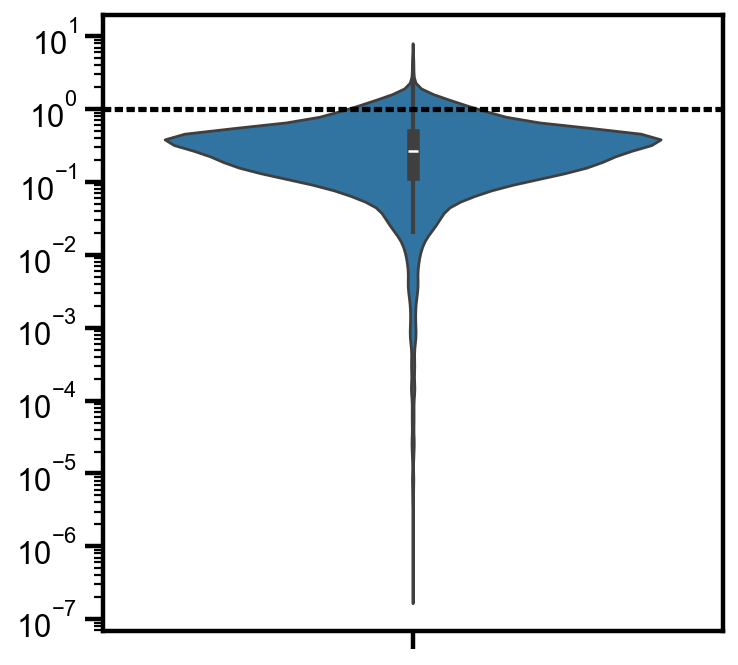

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale('log')
sns.violinplot(
    lie_factor_df,
    ax=ax,
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

<Axes: ylabel='Count'>

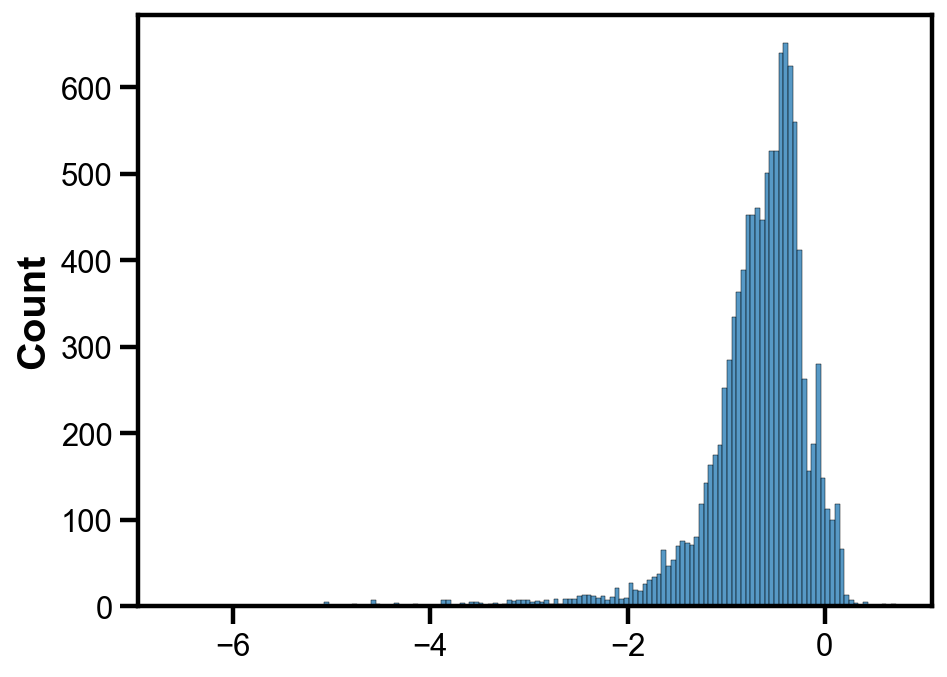

In [24]:
sns.histplot(np.log10(lie_factor_df))

### Zero

In [25]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', ZERO_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VAL_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [26]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    val_df = pd.read_csv(filepath, header=None, index_col=0)
    val_df = val_df.reset_index(drop=True)
    val_series = val_df.iloc[:, 0]
    val_series.name = 'Data Value'
    val_effect_series = get_size_of_effect(val_series)
    raw_df_dict[fignames[i]] = val_effect_series

In [27]:
val_series = pd.concat(raw_df_dict)
val_series

10.1038:s41551-023-01136-9_zero_fig11  0    0.170132
                                       1   -0.145396
10.1038:s41551-023-01106-1_zero_fig6   0    0.220447
                                       1   -0.180628
10.1038:s41551-023-01134-x_zero_fig4   0    0.730263
                                              ...   
10.1038:s41551-023-01106-1_zero_fig11  1    0.113815
                                       2   -0.027159
                                       3    0.083565
                                       4   -0.102185
                                       5   -0.077121
Length: 2532, dtype: float64

In [28]:
filepath = os.path.join(DATA_DIR, MISUSED_BAR_DIR, 'nat_biomed_eng', ZERO_SUBDIR)
filenames = os.listdir(filepath)
filenames = pd.Series(filenames)
filenames = filenames[filenames.str.contains(CSV_FILEEXT) & filenames.str.contains(VIZ_LABEL)]
filenames = filenames.reset_index(drop=True)
fignames = filenames.str.slice(stop=-8)
filepaths = filepath + os.sep + filenames

In [29]:
raw_df_dict = {}
for i, filepath in enumerate(filepaths):
    viz_df = pd.read_csv(filepath, header=None, index_col=0)
    viz_df = viz_df.reset_index(drop=True)
    viz_series = viz_df.iloc[:, 0]
    viz_series.name = 'Data Value'
    viz_effect_series = get_size_of_effect(viz_series)
    raw_df_dict[fignames[i]] = viz_effect_series

In [30]:
viz_series = pd.concat(raw_df_dict)
viz_series

10.1038:s41551-023-01113-2_zero_fig1  0    -0.075342
                                      1    -0.150685
                                      2    -0.174658
                                      3     0.081481
                                      4    -0.081481
                                              ...   
10.1038:s41551-023-01138-7_zero_fig1  25    4.360000
                                      26    2.253333
                                      27    3.186667
                                      28    0.800000
                                      29    1.373333
Length: 2532, dtype: float64

In [31]:
lie_factor_df = get_lie_factor(viz_series, val_series)
lie_factor_df

10.1038:s41551-022-00991-2_zero_fig1  0    3.573529
                                      1    3.573529
                                      2    3.573529
                                      3    3.560976
                                      4    3.560976
                                             ...   
10.1038_s41551-023-01136-9_zero_fig7  1    1.439394
                                      2    1.972067
                                      3    1.972067
                                      4    1.480663
                                      5    1.480663
Length: 2532, dtype: float64

In [32]:
# sanity check: no negative lie factor unless manually identified (e.g. negative value represented by positive bars)
# allowed: 10.1038:s41551-023-01138-7_zero_fig1
# figures with negative lie factor
np.unique(lie_factor_df[lie_factor_df < 0].index.get_level_values(0))

array(['10.1038:s41551-023-01138-7_zero_fig1'], dtype=object)

In [33]:
lie_factor_df.min()

-0.026666666666666467

In [34]:
lie_factor_df.max()

34.46058091286281

In [35]:
lie_factor_df.median()

2.199608610567514

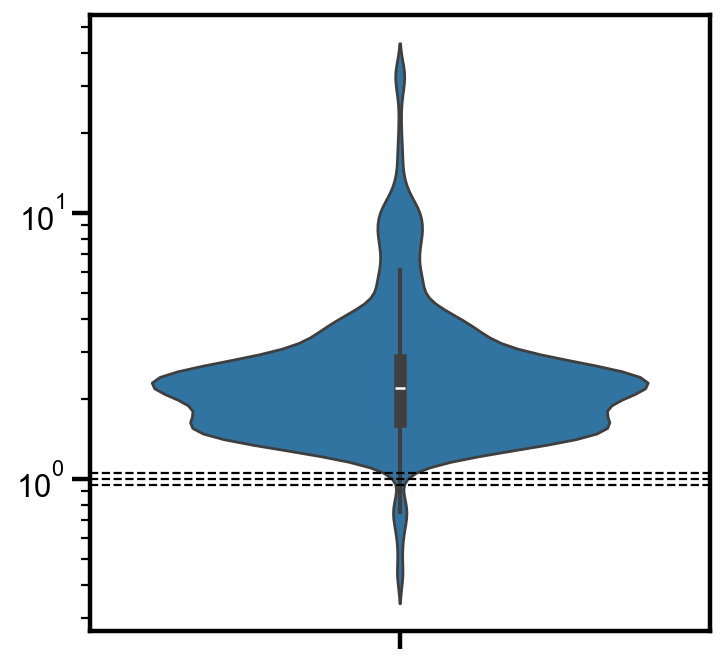

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_yscale('log')
sns.violinplot(
    lie_factor_df[lie_factor_df > 0],
    ax=ax,
)
ax.axhline(1, color='k', ls='--', lw=1)
ax.axhline(1.05, color='k', ls='--', lw=1)
ax.axhline(0.95, color='k', ls='--', lw=1)

<Axes: ylabel='Count'>

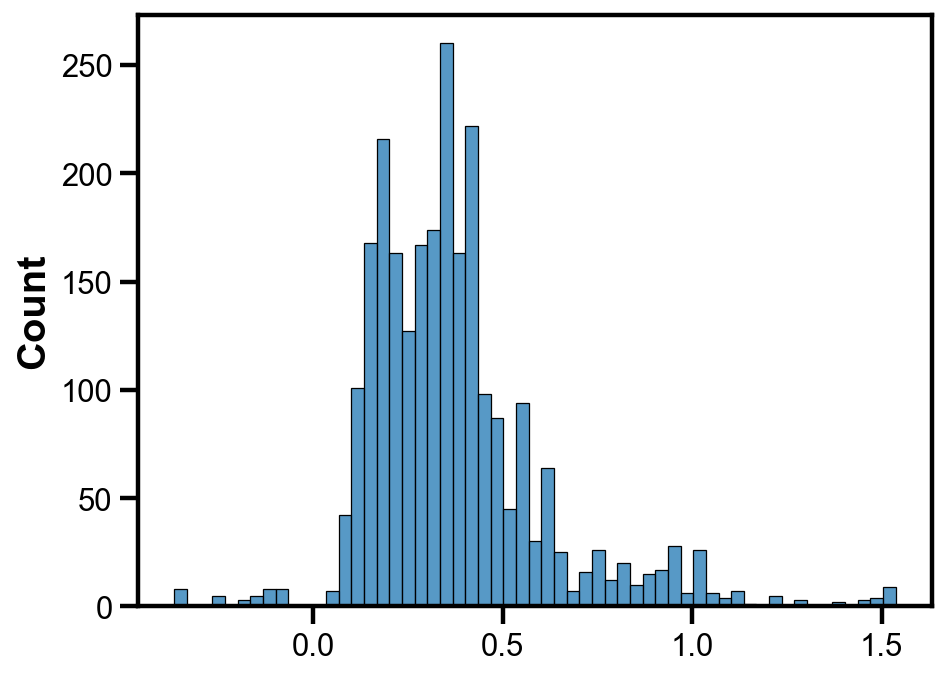

In [37]:
sns.histplot(np.log10(lie_factor_df))